# Nibbler (Snake) con Reinforcement Learning

En este notebook crearemos un entorno del clásico juego **Nibbler/Snake** y entrenaremos un agente de RL para jugarlo.

## Contenido
1. [Crear el Entorno](#1-entorno)
2. [Visualización del Juego](#2-visualizacion)
3. [Agente DQN](#3-agente)
4. [Entrenamiento](#4-entrenamiento)
5. [Evaluación y Demo](#5-evaluacion)

---

In [21]:
# Imports necesarios
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import random
from collections import deque
from IPython.display import clear_output
import time

# Gymnasium
try:
    import gymnasium as gym
    from gymnasium import spaces
except ImportError:
    !pip install gymnasium -q
    import gymnasium as gym
    from gymnasium import spaces

# PyTorch para DQN
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    TORCH_AVAILABLE = True
    print(f"✅ PyTorch disponible (device: {'cuda' if torch.cuda.is_available() else 'cpu'})")
except ImportError:
    TORCH_AVAILABLE = False
    print("⚠️ PyTorch no disponible. Instala con: pip install torch")

%matplotlib inline
print("✅ Imports cargados")

✅ PyTorch disponible (device: cuda)
✅ Imports cargados


---
<a id='1-entorno'></a>
# 1. Crear el Entorno Nibbler

Vamos a crear un entorno compatible con Gymnasium para el juego de la serpiente.

## Reglas del Juego
- La serpiente se mueve en una cuadrícula
- Puede ir: ↑ Arriba, → Derecha, ↓ Abajo, ← Izquierda
- Come comida (manzanas) para crecer y ganar puntos
- Muere si choca con las paredes o consigo misma
- Objetivo: Sobrevivir el mayor tiempo posible y comer mucho

## Representación
- `0` = Celda vacía
- `1` = Cuerpo de la serpiente
- `2` = Cabeza de la serpiente
- `3` = Comida

In [22]:
class NibblerEnv(gym.Env):
    """
    Entorno del juego Nibbler (Snake) compatible con Gymnasium.
    
    Observación: Matriz grid_size x grid_size con valores:
        0 = vacío, 1 = cuerpo, 2 = cabeza, 3 = comida
    
    Acciones: 0=arriba, 1=derecha, 2=abajo, 3=izquierda
    
    Recompensas:
        +10 por comer comida
        -10 por morir
        +0.1 por acercarse a la comida
        -0.1 por alejarse de la comida
    """
    
    metadata = {'render_modes': ['human', 'rgb_array']}
    
    def __init__(self, grid_size=10, render_mode=None):
        super().__init__()
        
        self.grid_size = grid_size
        self.render_mode = render_mode
        
        # Espacio de acciones: 4 direcciones
        self.action_space = spaces.Discrete(4)
        
        # Espacio de observación: grid con valores 0-3
        self.observation_space = spaces.Box(
            low=0, high=3,
            shape=(grid_size, grid_size),
            dtype=np.uint8
        )
        
        # Direcciones: arriba, derecha, abajo, izquierda
        self.directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        self.direction_names = ['↑', '→', '↓', '←']
        
        # Estado del juego
        self.snake = None
        self.food = None
        self.direction = None
        self.score = 0
        self.steps = 0
        self.max_steps = grid_size * grid_size * 2  # Límite de pasos
        
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        # Inicializar serpiente en el centro
        center = self.grid_size // 2
        self.snake = deque([(center, center)])
        self.direction = 1  # Empezar yendo a la derecha
        self.score = 0
        self.steps = 0
        
        # Colocar comida
        self._place_food()
        
        return self._get_observation(), {}
    
    def _place_food(self):
        """Coloca la comida en una posición aleatoria libre."""
        empty_cells = []
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if (i, j) not in self.snake:
                    empty_cells.append((i, j))
        
        if empty_cells:
            self.food = random.choice(empty_cells)
        else:
            self.food = None  # Serpiente llena todo el tablero (victoria)
    
    def _get_observation(self):
        """Devuelve el estado del tablero como matriz."""
        grid = np.zeros((self.grid_size, self.grid_size), dtype=np.uint8)
        
        # Cuerpo de la serpiente
        for segment in self.snake:
            grid[segment[0], segment[1]] = 1
        
        # Cabeza
        head = self.snake[0]
        grid[head[0], head[1]] = 2
        
        # Comida
        if self.food:
            grid[self.food[0], self.food[1]] = 3
        
        return grid
    
    def _distance_to_food(self, pos):
        """Distancia Manhattan a la comida."""
        if self.food is None:
            return 0
        return abs(pos[0] - self.food[0]) + abs(pos[1] - self.food[1])
    
    def step(self, action):
        self.steps += 1
        
        # Evitar que la serpiente vaya en dirección opuesta (muerte instantánea)
        opposite = (self.direction + 2) % 4
        if action == opposite and len(self.snake) > 1:
            action = self.direction  # Mantener dirección actual
        
        self.direction = action
        
        # Calcular nueva posición de la cabeza
        head = self.snake[0]
        delta = self.directions[action]
        new_head = (head[0] + delta[0], head[1] + delta[1])
        
        # Distancia antes del movimiento
        dist_before = self._distance_to_food(head)
        
        # Verificar colisiones
        terminated = False
        truncated = False
        reward = 0
        
        # Colisión con paredes
        if (new_head[0] < 0 or new_head[0] >= self.grid_size or
            new_head[1] < 0 or new_head[1] >= self.grid_size):
            terminated = True
            reward = -10
        
        # Colisión consigo misma
        elif new_head in self.snake:
            terminated = True
            reward = -10
        
        else:
            # Mover la serpiente
            self.snake.appendleft(new_head)
            
            # ¿Comió comida?
            if new_head == self.food:
                self.score += 1
                reward = 10
                self._place_food()
                
                # Victoria: serpiente llena todo
                if self.food is None:
                    terminated = True
                    reward = 100
            else:
                # No comió, quitar la cola
                self.snake.pop()
                
                # Recompensa por acercarse/alejarse de la comida
                dist_after = self._distance_to_food(new_head)
                if dist_after < dist_before:
                    reward = 0.1  # Se acercó
                else:
                    reward = -0.1  # Se alejó
        
        # Límite de pasos (evitar loops infinitos)
        if self.steps >= self.max_steps:
            truncated = True
        
        info = {'score': self.score, 'length': len(self.snake)}
        
        return self._get_observation(), reward, terminated, truncated, info
    
    def render(self):
        """Renderiza el estado actual del juego."""
        grid = self._get_observation()
        
        # Símbolos para visualización en consola
        symbols = {0: '·', 1: '█', 2: '▓', 3: '🍎'}
        
        print("┌" + "─" * (self.grid_size * 2 - 1) + "┐")
        for row in grid:
            line = "│"
            for cell in row:
                line += symbols[cell] + " " if cell != 3 else symbols[cell]
            print(line.rstrip() + "│")
        print("└" + "─" * (self.grid_size * 2 - 1) + "┘")
        print(f"Score: {self.score} | Length: {len(self.snake)} | Steps: {self.steps}")
    
    def render_matplotlib(self, ax=None):
        """Renderiza usando matplotlib para visualización en notebook."""
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))
        
        grid = self._get_observation()
        
        # Colores: vacío=blanco, cuerpo=verde, cabeza=verde oscuro, comida=rojo
        cmap = colors.ListedColormap(['white', '#90EE90', '#228B22', 'red'])
        bounds = [0, 1, 2, 3, 4]
        norm = colors.BoundaryNorm(bounds, cmap.N)
        
        ax.imshow(grid, cmap=cmap, norm=norm)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'Score: {self.score} | Length: {len(self.snake)}')
        
        # Dibujar cuadrícula
        for i in range(self.grid_size + 1):
            ax.axhline(i - 0.5, color='gray', linewidth=0.5)
            ax.axvline(i - 0.5, color='gray', linewidth=0.5)
        
        return ax


# Probar el entorno
print("=" * 50)
print("ENTORNO NIBBLER CREADO")
print("=" * 50)

env = NibblerEnv(grid_size=8)
obs, info = env.reset(seed=42)

print(f"\nEspacio de observación: {env.observation_space}")
print(f"Espacio de acciones: {env.action_space}")
print(f"Acciones: 0=↑, 1=→, 2=↓, 3=←")
print(f"\nEstado inicial:")
env.render()

ENTORNO NIBBLER CREADO

Espacio de observación: Box(0, 3, (8, 8), uint8)
Espacio de acciones: Discrete(4)
Acciones: 0=↑, 1=→, 2=↓, 3=←

Estado inicial:
┌───────────────┐
│· · · · · · · ·│
│· · · · · · · ·│
│· · · · · · · 🍎│
│· · · · · · · ·│
│· · · · ▓ · · ·│
│· · · · · · · ·│
│· · · · · · · ·│
│· · · · · · · ·│
└───────────────┘
Score: 0 | Length: 1 | Steps: 0


---
<a id='2-visualizacion'></a>
# 2. Visualización del Juego

Vamos a probar el entorno con un agente aleatorio y visualizarlo.

AGENTE ALEATORIO JUGANDO

Juego terminado en paso 23
Score final: 0
Longitud final: 1
Recompensa total: -9.6


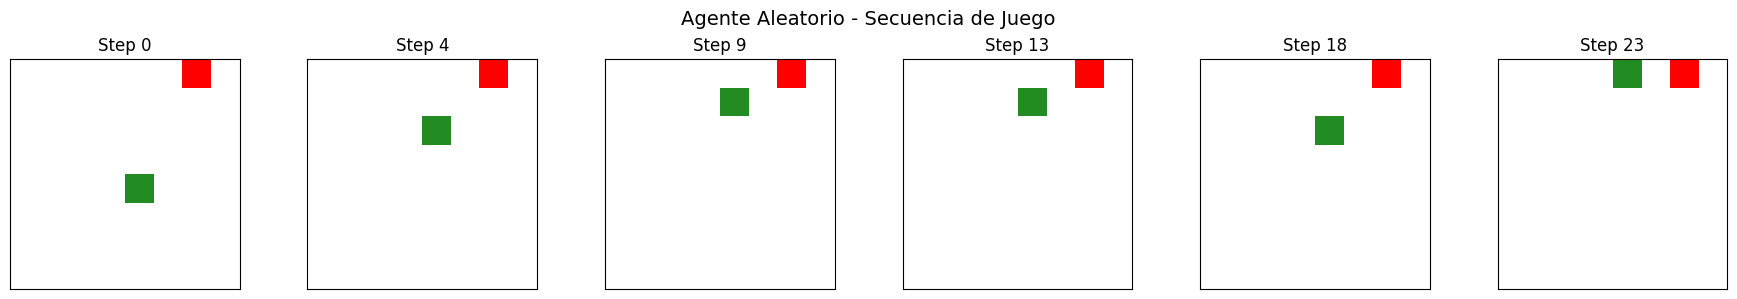

In [23]:
# Jugar un episodio con agente aleatorio
env = NibblerEnv(grid_size=8)
obs, info = env.reset(seed=123)

print("=" * 50)
print("AGENTE ALEATORIO JUGANDO")
print("=" * 50)

frames = [env._get_observation().copy()]
total_reward = 0

for step in range(50):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    frames.append(obs.copy())
    
    if terminated or truncated:
        print(f"\nJuego terminado en paso {step + 1}")
        print(f"Score final: {info['score']}")
        print(f"Longitud final: {info['length']}")
        print(f"Recompensa total: {total_reward:.1f}")
        break

# Mostrar algunos frames
n_frames = min(6, len(frames))
fig, axes = plt.subplots(1, n_frames, figsize=(3 * n_frames, 3))

indices = np.linspace(0, len(frames) - 1, n_frames, dtype=int)
cmap = colors.ListedColormap(['white', '#90EE90', '#228B22', 'red'])

for ax, idx in zip(axes, indices):
    ax.imshow(frames[idx], cmap=cmap, vmin=0, vmax=3)
    ax.set_title(f'Step {idx}')
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle('Agente Aleatorio - Secuencia de Juego', fontsize=14)
plt.tight_layout()
plt.show()

In [24]:
# Animación interactiva (ejecutar varias veces para ver diferentes partidas)
def jugar_episodio_animado(env, agente=None, delay=0.2, max_steps=100):
    """Juega un episodio mostrando la animación."""
    obs, info = env.reset()
    total_reward = 0
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    for step in range(max_steps):
        clear_output(wait=True)
        
        ax.clear()
        env.render_matplotlib(ax)
        ax.set_title(f'Step: {step} | Score: {env.score} | Reward: {total_reward:.1f}')
        plt.pause(0.01)
        display(fig)
        
        if agente is not None:
            action = agente.seleccionar_accion(obs)
        else:
            action = env.action_space.sample()
        
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        
        time.sleep(delay)
        
        if terminated or truncated:
            break
    
    plt.close()
    print(f"\n🎮 Juego terminado")
    print(f"   Score: {info['score']}")
    print(f"   Longitud: {info['length']}")
    print(f"   Recompensa total: {total_reward:.1f}")
    
    return info['score'], total_reward

# Descomentar para ver animación (tarda un poco)
# env = NibblerEnv(grid_size=8)
# jugar_episodio_animado(env, delay=0.15, max_steps=50)

---
<a id='3-agente'></a>
# 3. Agente DQN

Crearemos un agente DQN que aprenda a jugar al Nibbler.

## Arquitectura
- **Input**: Estado del tablero (grid_size × grid_size)
- **Red**: CNN para procesar la cuadrícula
- **Output**: Q-valor para cada una de las 4 acciones

In [25]:
if not TORCH_AVAILABLE:
    print("⚠️ PyTorch no disponible. Salta a la siguiente sección.")
else:
    
    class ReplayBuffer:
        """Buffer para Experience Replay."""
        
        def __init__(self, capacity=50000):
            self.buffer = deque(maxlen=capacity)
        
        def push(self, state, action, reward, next_state, done):
            self.buffer.append((state, action, reward, next_state, done))
        
        def sample(self, batch_size):
            batch = random.sample(self.buffer, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)
            return (np.array(states), np.array(actions), np.array(rewards, dtype=np.float32),
                    np.array(next_states), np.array(dones, dtype=np.float32))
        
        def __len__(self):
            return len(self.buffer)
    
    
    class DQNNetwork(nn.Module):
        """Red neuronal convolucional para el Nibbler."""
        
        def __init__(self, grid_size, n_actions=4):
            super().__init__()
            
            self.conv = nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(),
            )
            
            conv_out_size = 64 * grid_size * grid_size
            
            self.fc = nn.Sequential(
                nn.Flatten(),
                nn.Linear(conv_out_size, 256),
                nn.ReLU(),
                nn.Linear(256, n_actions)
            )
        
        def forward(self, x):
            # x shape: (batch, grid_size, grid_size)
            if x.dim() == 2:
                x = x.unsqueeze(0)  # Añadir batch dim
            if x.dim() == 3:
                x = x.unsqueeze(1)  # Añadir channel dim
            
            x = x.float() / 3.0  # Normalizar a [0, 1]
            x = self.conv(x)
            x = self.fc(x)
            return x
    
    
    class DQNAgent:
        """Agente DQN para el Nibbler."""
        
        def __init__(self, grid_size, n_actions=4, lr=0.0005, gamma=0.99,
                     epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.9995,
                     buffer_size=50000, batch_size=64, target_update=100):
            
            self.grid_size = grid_size
            self.n_actions = n_actions
            self.gamma = gamma
            self.epsilon = epsilon
            self.epsilon_min = epsilon_min
            self.epsilon_decay = epsilon_decay
            self.batch_size = batch_size
            self.target_update = target_update
            self.learn_step = 0
            
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            
            # Redes
            self.q_network = DQNNetwork(grid_size, n_actions).to(self.device)
            self.target_network = DQNNetwork(grid_size, n_actions).to(self.device)
            self.target_network.load_state_dict(self.q_network.state_dict())
            
            self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
            self.loss_fn = nn.MSELoss()
            
            self.memory = ReplayBuffer(buffer_size)
        
        def seleccionar_accion(self, state):
            """Selecciona acción con ε-greedy."""
            if random.random() < self.epsilon:
                return random.randint(0, self.n_actions - 1)
            
            with torch.no_grad():
                state_t = torch.tensor(state, dtype=torch.float32).to(self.device)
                q_values = self.q_network(state_t)
                return q_values.argmax().item()
        
        def almacenar(self, state, action, reward, next_state, done):
            """Almacena transición en el buffer."""
            self.memory.push(state, action, reward, next_state, done)
        
        def entrenar(self):
            """Realiza un paso de entrenamiento."""
            if len(self.memory) < self.batch_size:
                return 0
            
            # Samplear batch
            states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
            
            states_t = torch.tensor(states, dtype=torch.float32).to(self.device)
            actions_t = torch.tensor(actions, dtype=torch.long).to(self.device)
            rewards_t = torch.tensor(rewards, dtype=torch.float32).to(self.device)
            next_states_t = torch.tensor(next_states, dtype=torch.float32).to(self.device)
            dones_t = torch.tensor(dones, dtype=torch.float32).to(self.device)
            
            # Q-valores actuales
            q_values = self.q_network(states_t)
            q_value = q_values.gather(1, actions_t.unsqueeze(1)).squeeze(1)
            
            # Q-valores target
            with torch.no_grad():
                next_q_values = self.target_network(next_states_t)
                next_q_value = next_q_values.max(1)[0]
                target = rewards_t + (1 - dones_t) * self.gamma * next_q_value
            
            # Calcular pérdida
            loss = self.loss_fn(q_value, target)
            
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
            self.optimizer.step()
            
            # Actualizar target network
            self.learn_step += 1
            if self.learn_step % self.target_update == 0:
                self.target_network.load_state_dict(self.q_network.state_dict())
            
            return loss.item()
        
        def decay_epsilon(self):
            """Reduce epsilon."""
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        
        def guardar(self, path):
            """Guarda el modelo."""
            torch.save({
                'q_network': self.q_network.state_dict(),
                'target_network': self.target_network.state_dict(),
                'optimizer': self.optimizer.state_dict(),
                'epsilon': self.epsilon
            }, path)
        
        def cargar(self, path):
            """Carga un modelo guardado."""
            checkpoint = torch.load(path, map_location=self.device)
            self.q_network.load_state_dict(checkpoint['q_network'])
            self.target_network.load_state_dict(checkpoint['target_network'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            self.epsilon = checkpoint['epsilon']
    
    
    print("✅ Agente DQN definido")
    print(f"   Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

✅ Agente DQN definido
   Device: cuda


---
<a id='4-entrenamiento'></a>
# 4. Entrenamiento

Entrenaremos el agente durante varios episodios.

In [26]:
if not TORCH_AVAILABLE:
    print("⚠️ PyTorch no disponible.")
else:
    def entrenar_nibbler(grid_size=8, n_episodios=500, verbose=True):
        """Entrena el agente DQN en el Nibbler."""
        
        env = NibblerEnv(grid_size=grid_size)
        agente = DQNAgent(
            grid_size=grid_size,
            lr=0.0005,
            gamma=0.95,
            epsilon=1.0,
            epsilon_min=0.05,
            epsilon_decay=0.9995,
            batch_size=64,
            target_update=100
        )
        
        # Métricas
        scores = []
        rewards = []
        lengths = []
        losses = []
        
        best_score = 0
        
        for ep in range(n_episodios):
            state, _ = env.reset()
            total_reward = 0
            total_loss = 0
            steps = 0
            
            while True:
                action = agente.seleccionar_accion(state)
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                
                agente.almacenar(state, action, reward, next_state, done)
                loss = agente.entrenar()
                
                total_reward += reward
                total_loss += loss
                steps += 1
                state = next_state
                
                if done:
                    break
            
            agente.decay_epsilon()
            
            scores.append(info['score'])
            rewards.append(total_reward)
            lengths.append(info['length'])
            losses.append(total_loss / max(steps, 1))
            
            if info['score'] > best_score:
                best_score = info['score']
                agente.guardar('nibbler_best.pth')
            
            if verbose and (ep + 1) % 50 == 0:
                avg_score = np.mean(scores[-50:])
                avg_reward = np.mean(rewards[-50:])
                print(f"Ep {ep+1:4d} | Score: {info['score']:2d} | Avg: {avg_score:.1f} | "
                      f"Best: {best_score} | ε: {agente.epsilon:.3f}")
        
        return agente, scores, rewards, lengths, losses
    
    # ENTRENAR
    print("=" * 60)
    print("ENTRENAMIENTO NIBBLER DQN")
    print("=" * 60)
    print("Grid: 8x8 | Episodios: 500")
    print("Esto puede tardar unos minutos...\n")
    
    agente, scores, rewards, lengths, losses = entrenar_nibbler(
        grid_size=8,
        n_episodios=500,
        verbose=True
    )
    
    print(f"\n✅ Entrenamiento completado")
    print(f"   Mejor score: {max(scores)}")
    print(f"   Score promedio (últimos 50): {np.mean(scores[-50:]):.1f}")

ENTRENAMIENTO NIBBLER DQN
Grid: 8x8 | Episodios: 500
Esto puede tardar unos minutos...

Ep   50 | Score:  0 | Avg: 0.1 | Best: 1 | ε: 0.975
Ep  100 | Score:  0 | Avg: 0.2 | Best: 1 | ε: 0.951
Ep  150 | Score:  0 | Avg: 0.2 | Best: 2 | ε: 0.928
Ep  200 | Score:  0 | Avg: 0.4 | Best: 3 | ε: 0.905
Ep  250 | Score:  0 | Avg: 0.2 | Best: 3 | ε: 0.882
Ep  300 | Score:  0 | Avg: 0.2 | Best: 3 | ε: 0.861
Ep  350 | Score:  0 | Avg: 0.3 | Best: 3 | ε: 0.839
Ep  400 | Score:  0 | Avg: 0.4 | Best: 3 | ε: 0.819
Ep  450 | Score:  0 | Avg: 0.2 | Best: 3 | ε: 0.798
Ep  500 | Score:  1 | Avg: 0.4 | Best: 3 | ε: 0.779

✅ Entrenamiento completado
   Mejor score: 3
   Score promedio (últimos 50): 0.4


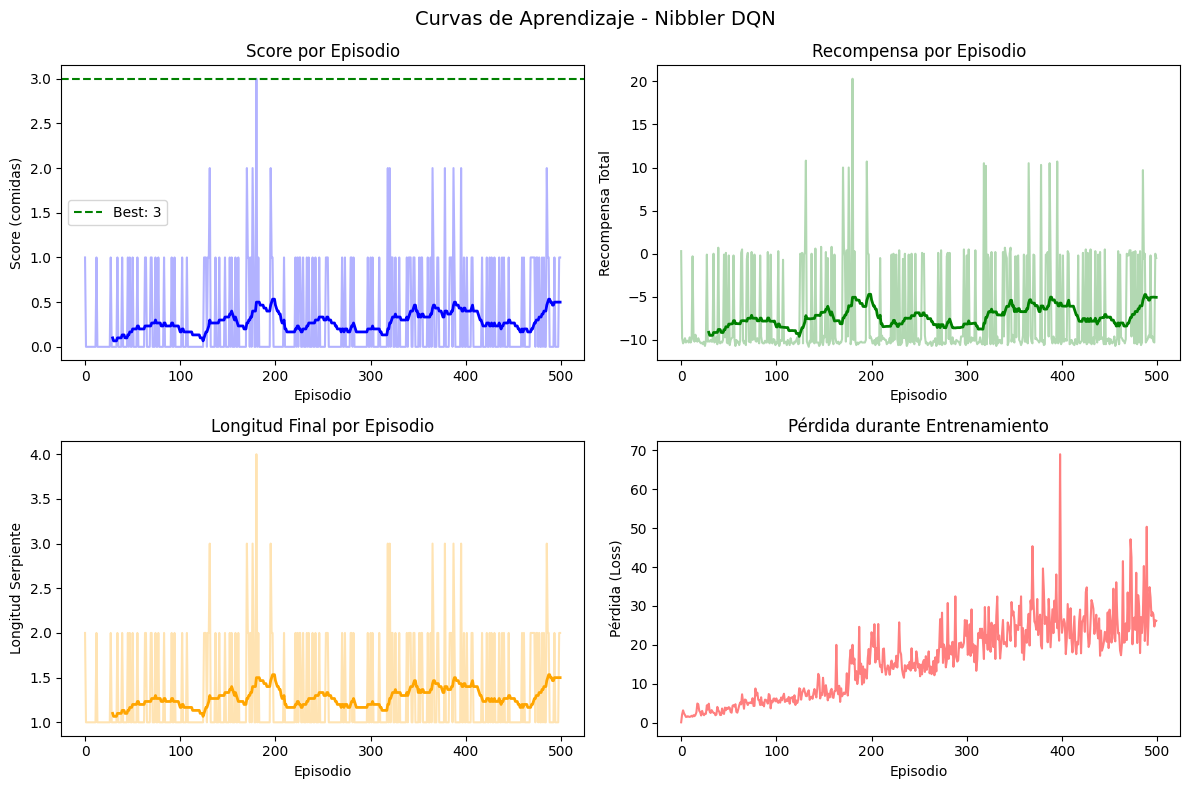


📊 Gráficos guardados en: nibbler_training.png


In [27]:
# Visualizar curvas de aprendizaje
if TORCH_AVAILABLE and 'scores' in dir():
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    window = 30
    
    # Score
    axes[0, 0].plot(scores, alpha=0.3, color='blue')
    if len(scores) >= window:
        scores_smooth = np.convolve(scores, np.ones(window)/window, mode='valid')
        axes[0, 0].plot(range(window-1, len(scores)), scores_smooth, color='blue', linewidth=2)
    axes[0, 0].set_xlabel('Episodio')
    axes[0, 0].set_ylabel('Score (comidas)')
    axes[0, 0].set_title('Score por Episodio')
    axes[0, 0].axhline(y=max(scores), color='green', linestyle='--', label=f'Best: {max(scores)}')
    axes[0, 0].legend()
    
    # Recompensa
    axes[0, 1].plot(rewards, alpha=0.3, color='green')
    if len(rewards) >= window:
        rewards_smooth = np.convolve(rewards, np.ones(window)/window, mode='valid')
        axes[0, 1].plot(range(window-1, len(rewards)), rewards_smooth, color='green', linewidth=2)
    axes[0, 1].set_xlabel('Episodio')
    axes[0, 1].set_ylabel('Recompensa Total')
    axes[0, 1].set_title('Recompensa por Episodio')
    
    # Longitud
    axes[1, 0].plot(lengths, alpha=0.3, color='orange')
    if len(lengths) >= window:
        lengths_smooth = np.convolve(lengths, np.ones(window)/window, mode='valid')
        axes[1, 0].plot(range(window-1, len(lengths)), lengths_smooth, color='orange', linewidth=2)
    axes[1, 0].set_xlabel('Episodio')
    axes[1, 0].set_ylabel('Longitud Serpiente')
    axes[1, 0].set_title('Longitud Final por Episodio')
    
    # Pérdida
    axes[1, 1].plot(losses, alpha=0.5, color='red')
    axes[1, 1].set_xlabel('Episodio')
    axes[1, 1].set_ylabel('Pérdida (Loss)')
    axes[1, 1].set_title('Pérdida durante Entrenamiento')
    
    plt.suptitle('Curvas de Aprendizaje - Nibbler DQN', fontsize=14)
    plt.tight_layout()
    plt.savefig('nibbler_training.png', dpi=150)
    plt.show()
    
    print("\n📊 Gráficos guardados en: nibbler_training.png")
else:
    print("⚠️ Primero ejecuta el entrenamiento")

---
<a id='5-evaluacion'></a>
# 5. Evaluación y Demo

Evaluamos el agente entrenado y vemos cómo juega.

In [28]:
if TORCH_AVAILABLE and 'agente' in dir():
    def evaluar_agente(env, agente, n_episodios=20):
        """Evalúa el agente sin exploración."""
        old_epsilon = agente.epsilon
        agente.epsilon = 0  # Greedy
        
        scores = []
        lengths = []
        
        for _ in range(n_episodios):
            state, _ = env.reset()
            
            while True:
                action = agente.seleccionar_accion(state)
                state, _, terminated, truncated, info = env.step(action)
                
                if terminated or truncated:
                    break
            
            scores.append(info['score'])
            lengths.append(info['length'])
        
        agente.epsilon = old_epsilon
        return scores, lengths
    
    # Evaluar
    print("=" * 50)
    print("EVALUACIÓN DEL AGENTE (20 episodios, sin exploración)")
    print("=" * 50)
    
    env = NibblerEnv(grid_size=8)
    eval_scores, eval_lengths = evaluar_agente(env, agente, n_episodios=20)
    
    print(f"\nScore: {np.mean(eval_scores):.1f} ± {np.std(eval_scores):.1f}")
    print(f"Mejor score: {max(eval_scores)}")
    print(f"Longitud promedio: {np.mean(eval_lengths):.1f}")
else:
    print("⚠️ Primero entrena el agente")

EVALUACIÓN DEL AGENTE (20 episodios, sin exploración)

Score: 0.4 ± 0.6
Mejor score: 2
Longitud promedio: 1.4


DEMO: Partida del Agente Entrenado

Resultado:
  Score: 0
  Longitud: 1
  Pasos: 100


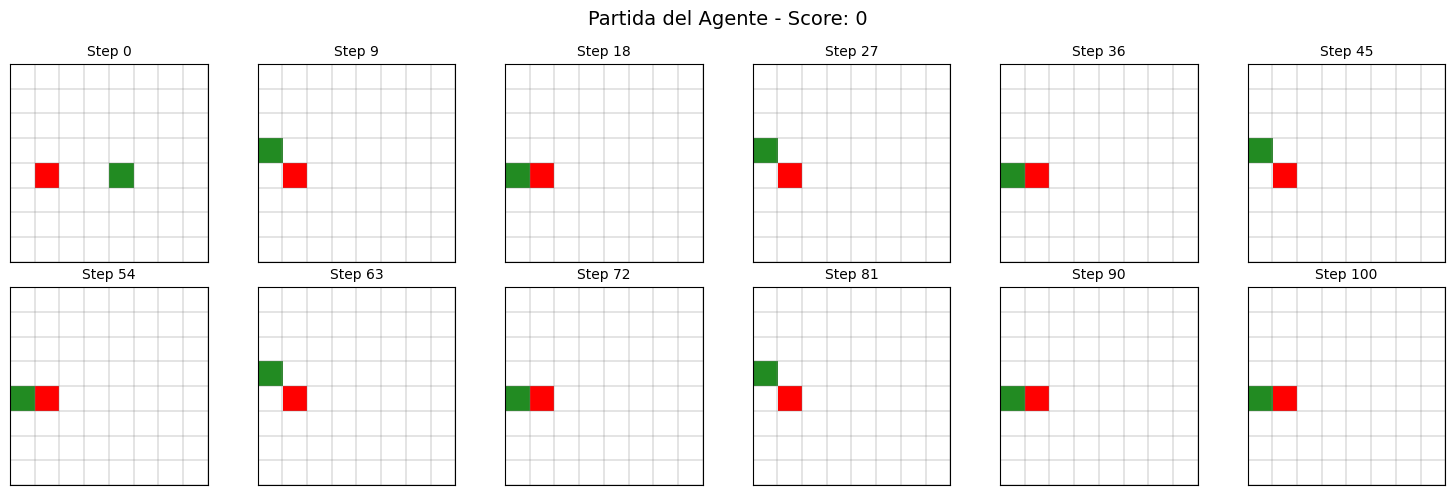

In [29]:
# Demo: Ver una partida del agente entrenado
if TORCH_AVAILABLE and 'agente' in dir():
    print("=" * 50)
    print("DEMO: Partida del Agente Entrenado")
    print("=" * 50)
    
    env = NibblerEnv(grid_size=8)
    state, _ = env.reset(seed=42)
    
    old_epsilon = agente.epsilon
    agente.epsilon = 0  # Sin exploración
    
    frames = [env._get_observation().copy()]
    actions_taken = []
    
    for step in range(100):
        action = agente.seleccionar_accion(state)
        actions_taken.append(action)
        
        state, reward, terminated, truncated, info = env.step(action)
        frames.append(env._get_observation().copy())
        
        if terminated or truncated:
            break
    
    agente.epsilon = old_epsilon
    
    print(f"\nResultado:")
    print(f"  Score: {info['score']}")
    print(f"  Longitud: {info['length']}")
    print(f"  Pasos: {len(frames) - 1}")
    
    # Mostrar frames de la partida
    n_show = min(12, len(frames))
    indices = np.linspace(0, len(frames) - 1, n_show, dtype=int)
    
    fig, axes = plt.subplots(2, 6, figsize=(15, 5))
    axes = axes.flatten()
    
    cmap = colors.ListedColormap(['white', '#90EE90', '#228B22', 'red'])
    
    for ax, idx in zip(axes, indices):
        ax.imshow(frames[idx], cmap=cmap, vmin=0, vmax=3)
        ax.set_title(f'Step {idx}', fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        
        for i in range(9):
            ax.axhline(i - 0.5, color='gray', linewidth=0.3)
            ax.axvline(i - 0.5, color='gray', linewidth=0.3)
    
    plt.suptitle(f'Partida del Agente - Score: {info["score"]}', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Primero entrena el agente")

In [30]:
# Animación en tiempo real (descomentar para ver)
if TORCH_AVAILABLE and 'agente' in dir():
    print("Descomenta el código de abajo para ver la animación en tiempo real")
    
    # env = NibblerEnv(grid_size=8)
    # agente.epsilon = 0
    # jugar_episodio_animado(env, agente, delay=0.2, max_steps=150)

Descomenta el código de abajo para ver la animación en tiempo real


---

# Resumen

En este notebook hemos:

1. **Creado un entorno custom** compatible con Gymnasium para el juego Nibbler/Snake
2. **Implementado un agente DQN** con CNN para procesar el tablero
3. **Entrenado el agente** durante 500 episodios
4. **Evaluado y visualizado** el comportamiento aprendido

## Ideas para Mejorar

- Usar **Double DQN** o **Dueling DQN** para mejor estabilidad
- Añadir **más información al estado** (dirección actual, distancia a comida)
- Probar con **grids más grandes** (10x10, 15x15)
- Implementar **reward shaping** más sofisticado
- Usar **prioritized experience replay**

## Para la Práctica Final

Puedes usar este entorno como base para tu práctica. Modifica:
- El tamaño del grid
- La arquitectura de la red
- Los hiperparámetros
- El sistema de recompensas

---

## 🐍 Variantes de Entrenamiento — Nibbler (Snake)

Las variantes en Nibbler exploran una pregunta fundamental: **¿cómo diseñar la función de recompensa?**

El entorno es simple (grid 15×15, 4 acciones) pero la función de reward tiene un impacto enorme en el comportamiento aprendido.

| Variante | Nombre | Reward extra | Concepto |
|----------|--------|-------------|---------|
| A | Estándar *(actual)* | Ninguno | Comida +10, muerte -10 |
| B | Reward Shaping | Bucles, exploración | Guiar el aprendizaje |
| C | Curiosidad Intrínseca | Error de predicción | Explorar lo desconocido |

### Variante A — DQN Estándar *(implementación actual)*

```python
python nibbler_game.py --train --variant standard
```

Función de recompensa original:
- `+10` al comer
- `-10` al chocar/morir
- `+0.1` por acercarse a la comida
- `-0.1` por alejarse de la comida

**Problema conocido**: el agente puede aprender a dar vueltas en círculos cerca de la comida (recibe +0.1 repetidamente sin arriesgarse). Es el comportamiento más seguro, no el más inteligente.

**Red neuronal**: [12 → 256 → 256 → 4]
**Estado**: 12 valores (4 peligros + 4 dirección + 4 posición comida)

In [ ]:
# Variante A: DQN Estándar
# from nibbler_game import train_agent
# agent, scores = train_agent(episodes=200)

print("Variante A: DQN Estándar")
print("  Estado: 12D [peligros(4) + dirección(4) + comida(4)]")
print("  Red: [12 → 256 → 256 → 4]")
print("  Reward: +10 comer, -10 morir, ±0.1 acercarse/alejarse")
print()
print("Función de reward original:")
reward_code = """
if new_head == self.food:
    reward = 10      # Comió
elif colisión:
    reward = -10     # Murió
else:
    old_dist = distancia_manhattan(head, food)
    new_dist = distancia_manhattan(new_head, food)
    reward = 0.1 if new_dist < old_dist else -0.1
"""
print(reward_code)

### Variante B — Reward Shaping

```python
python nibbler_game.py --train --variant shaped
```

El reward shaping **añade señales adicionales** para desalentar comportamientos no deseados y fomentar los deseados, sin cambiar la solución óptima.

**Señales añadidas**:
| Condición | Reward extra |
|-----------|-------------|
| Visita posición repetida (últimas 20) | -2.0 (penaliza bucles) |
| >50 pasos sin comer | -0.5 (penaliza estancamiento) |
| Visita celda nueva (no vista este ep.) | +0.2 (premia exploración) |

**Resultado esperado**: la serpiente explora más el tablero en lugar de circular cerca de la comida.

**Nota teórica**: el reward shaping es válido si es *potential-based* (Ng et al., 1999), lo que garantiza que no cambia la política óptima. Aquí es una aproximación práctica.

In [ ]:
# Variante B: Reward Shaping
# from nibbler_game import train_shaped
# agent, scores = train_shaped(episodes=200)

print("Variante B: Reward Shaping")
print()
shaping_code = """
# Variables de seguimiento por episodio
visited_cells = set()      # Celdas visitadas este episodio
steps_since_food = 0       # Pasos sin comer
recent_positions = deque(maxlen=20)  # Posiciones recientes

# Cada paso:
if base_reward == 10:
    # Comió: resetear contadores
    steps_since_food = 0
    visited_cells = set(game.snake)
else:
    steps_since_food += 1
    
    # Penalizar bucles
    if head in recent_positions:
        shaped_reward -= 2.0
    
    # Penalizar no comer mucho tiempo
    if steps_since_food > 50:
        shaped_reward -= 0.5
    
    # Premiar exploración
    if head not in visited_cells:
        shaped_reward += 0.2
        visited_cells.add(head)

recent_positions.append(head)
"""
print(shaping_code)

### Variante C — Curiosidad Intrínseca (ICM)

```python
python nibbler_game.py --train --variant curiosity
```

La curiosidad intrínseca es un mecanismo de exploración donde el agente recibe **recompensa por sorprenderse a sí mismo**.

**Cómo funciona el módulo ICM (Intrinsic Curiosity Module)**:
1. Se entrena un *modelo de transición* que aprende a predecir `next_state` dado `(state, action)`
2. En cada paso: error_predicción = MSE(predicción, next_state_real)
3. `reward_total = reward_extrínseca + λ × error_predicción`

**Intuición**: Si el agente visita un estado que nunca ha visto, el modelo de transición falla mucho en predecirlo → alto error → alta recompensa intrínseca → el agente tiene incentivo para explorar ese estado.

**Resultado esperado**: el agente explora todo el tablero antes de centrarse en buscar comida.

```
┌─────────────────────────────────────────────┐
│  estado_t  ──┐                              │
│              ├──► Modelo de Transición ──►  │
│  acción_t  ──┘         │                   │
│                         ▼                   │
│              error = MSE(pred, real)        │
│              reward_intrínseca = error      │
└─────────────────────────────────────────────┘
```

*Referencia: Pathak et al., 2017 — "Curiosity-driven Exploration by Self-Supervised Prediction"*

In [ ]:
# Variante C: Curiosidad Intrínseca
# from nibbler_game import train_curiosity
# agent, scores, intrinsic_hist = train_curiosity(episodes=200, curiosity_scale=0.5)

print("Variante C: Curiosidad Intrínseca")
print()
icm_code = """
# Módulo de curiosidad: predice next_state
class CuriosityModule(nn.Module):
    def __init__(self, state_size=12, n_actions=4):
        self.forward_model = nn.Sequential(
            nn.Linear(state_size + n_actions, 64),  # state + one-hot action
            nn.ReLU(),
            nn.Linear(64, state_size)               # predice next_state
        )

# En cada paso del entrenamiento:
# 1. Calcular recompensa intrínseca (error de predicción)
intrinsic = curiosity.intrinsic_reward(state, action, next_state)

# 2. Combinar con recompensa extrínseca
total_reward = extrinsic_reward + curiosity_scale * intrinsic

# 3. Mejorar el modelo de transición
curiosity.train_step(state, action, next_state)

# 4. Entrenar el agente con la recompensa combinada
agent.remember(state, action, total_reward, next_state, done)
"""
print(icm_code)
print("Hiperparámetro clave: curiosity_scale")
print("  0.1 → curiosidad baja, prioriza recompensa real")
print("  0.5 → balanceado (default)")
print("  1.0 → alta exploración, puede ignorar la comida")

### Comparativa de Variantes

| Aspecto | A: Estándar | B: Shaping | C: Curiosidad |
|---------|-------------|------------|----------------|
| Convergencia | Media | Más rápida | Más lenta inicialmente |
| Comportamiento | Puede hacer bucles | Explora más | Explora todo |
| Complejidad | Baja | Media | Alta (módulo extra) |
| Scores iniciales | Bajos | Mejores | Muy bajos |
| Scores finales | Buenos | Buenos/mejores | Depende de escala |

**¿Cuándo usar cada una?**
- **A** — Baseline y comparación
- **B** — Cuando conoces comportamientos no deseados específicos
- **C** — Cuando el entorno es grande y la exploración es el principal problema